<font size="6"> Table of Contents</font>
<a id='destination_cell_10'></a> <br>
[Drop Rows and Transform Target Variable](#destination_cell_1) <br>
[Drop Nulls](#destination_cell_2)<br>
[Section 3](#destination_cell_3)<br>
[Section 4](#destination_cell_4)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import mstats
from scipy import stats 
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.linear_model import ElasticNet
from scipy.stats import mstats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA


from scipy.stats.mstats import winsorize

import scipy.stats as stats
from itertools import combinations
from joblib import load

In [2]:
%cd /Users/nicholassanso/Desktop/GA/projects/project-2

/Users/nicholassanso/Desktop/GA/projects/project-2


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df= pd.read_csv('./datasets/train.csv')

In [5]:
df.shape

(2051, 81)

In [6]:
new_columns = [column.replace(' ', '_').replace('/', '_').lower() for column in df.columns]

df.columns = new_columns
print(new_columns)

['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_drive', 'wood_deck_sf'

In [7]:
df['ms_subclass'] = df['ms_subclass'].apply(str)

<font size="8">Drop Rows and Transform Target Variable</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)


In [8]:
df = df.drop(columns=['garage_cars'])

Our model will only predict housing prices of residential housing in medium and low density. The features we have data on are much more likely to appear in those categories. Additionally, many of the quantitative square footage features would have different values in high density housing vs medium and low density housing, making vast swaths of the features confounding.

Direct Capitalizaiton method:
    (Net Operating Income)/(r-g)

A- Etirely different input costs from residential housing. top three input costs for farms in the United States
    1) Energy
    2) Seeds
    3) Pesticides
    
C- Far more sensitive to changes in the business cycle than residential.

I- Generally long build times keep the industrial ETFs out of sync with the business cycle altogether. Entirely different input costs

**Exclude ms_zoning variables from all the dataframes because it is a completely different regression variable <br>
Exclude garage_cars because it measures in a metric, "length of car" which is a nonstandardized and meaningless metric (we also already have garage_area which measures a something very similar)**

In [9]:
df.shape

(2051, 80)

In [10]:
#create a mask to drop rows
mask = df['ms_zoning'].isin(['C (all)', 'A (agr)', 'I (all)', 'RH', 'FV'])

#use mask to drop the rows in place
df.drop(df[mask].index, inplace=True)

In [11]:
df.shape

(1914, 80)

Ultimately we would like to predict the sales price of a house.<br> 

Embedded in some (65) of our sales price datapoints is the value of miscellanious features. misc_features is unique in the datatset as it is the only feature of a house in which we are also given its exact monetary value (and therefore contribution to the target variable, salesprice). As a result, we can get a more acurate understanding of the relationship between our predictor variables and our target variable (saleprice) if we remove the value of the miscellanious features from saleprice, as leaving its value in saleprice would serve as a counding variable. After removing the value of the miscellanious features from saleprice, we are no longer strictly predicting saleprice, but the portion of saleprice that is not attributable to the miscellanious features. <br>

Subtracting the value of the miscelanious features provides the additional benefit of not losing the predictive power of the the miscelanious variables in predicting salesprice and not having to incorporate a predictive variable in which the vast majority of its values are imputed. The histograms below underscroe this point and allow illustrate two conclusions: <br> 
1) The miscellanious features are mostly sheds of nominal value <br> 
2) Most of our observations don't have a miscellanious value <br> 
    2.a. If we included miscellanious feature as a our regression we would have to impute values for the nulls which comprise the vast majority of our obsevations. <br>

From these two conclusions, it is probably best to drop these two features altogether.

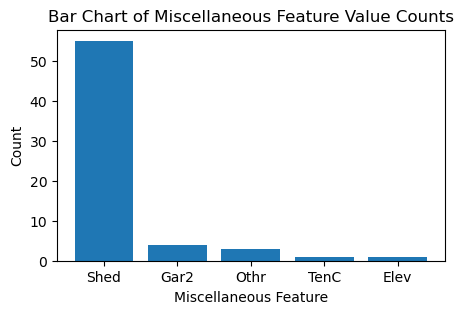

In [12]:
#get value counts
value_counts = df['misc_feature'].value_counts()

plt.figure(figsize=(5,3))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Miscellaneous Feature')
plt.ylabel('Count')
plt.title('Bar Chart of Miscellaneous Feature Value Counts')
plt.show()


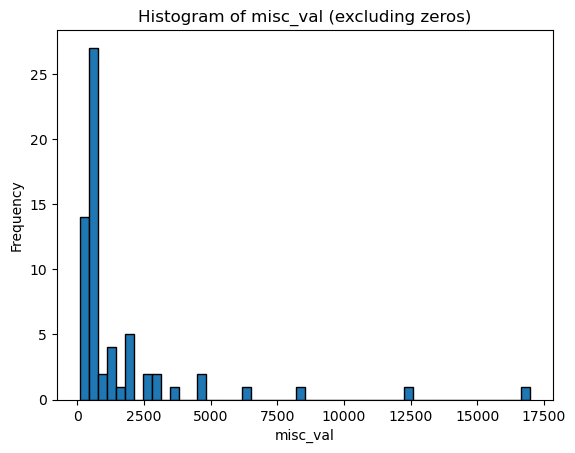

In [13]:
#Use the y-axis to gauge how few observations actually have miscellanious features and how many of the miscellanious features are of nominal value.

df_no_zeros = df[df['misc_val'] != 0]

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='black')
plt.title('Histogram of misc_val (excluding zeros)')
plt.xlabel('misc_val')
plt.ylabel('Frequency')
plt.show()

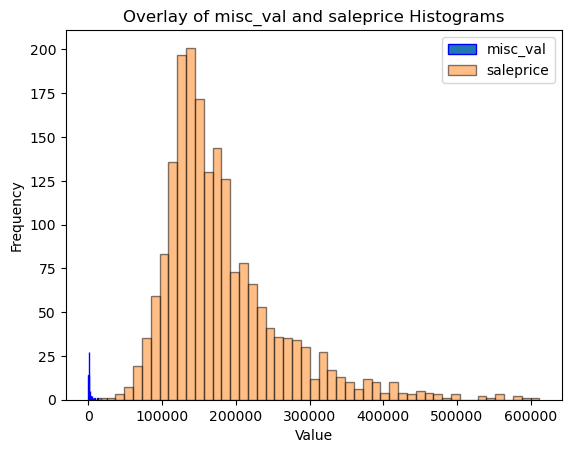

In [14]:
#plot the two histograms overlayed on one another to visually represent how immaterial misc_val is to saleprice as part of the
#justification for dropping the feature from the regression model.

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='blue', label='misc_val')
plt.hist(df['saleprice'], bins=50, edgecolor='black', alpha=0.5, label='saleprice')

plt.title('Overlay of misc_val and saleprice Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

**Some of the houses have high value miscelanious features like elevators. However, there is another feature, misc_value which specifically denotes the dollar amount of these features" so when training our model, we don't actually want to train it to predict saleprice, we want it to train to predict saleprice-misc_val, and then if a miscellanious item exists, to add on the value of the miscelleanious item at the end.**

In [15]:
df['saleprice-misc_val'] = df['saleprice'] - df['misc_val']

<font size="8"> Drop Nulls</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**We are looking here for a large gap in the number of missing values, if a large gap exists, then it will make our imputation threshold obvious. When getting rid of many variables with low single digit null values you run the risk that the indexes of the missing values don't match and that you are removing a large amount of data. We will drop all columns whose missing value perentage exceed the dotted red line.**

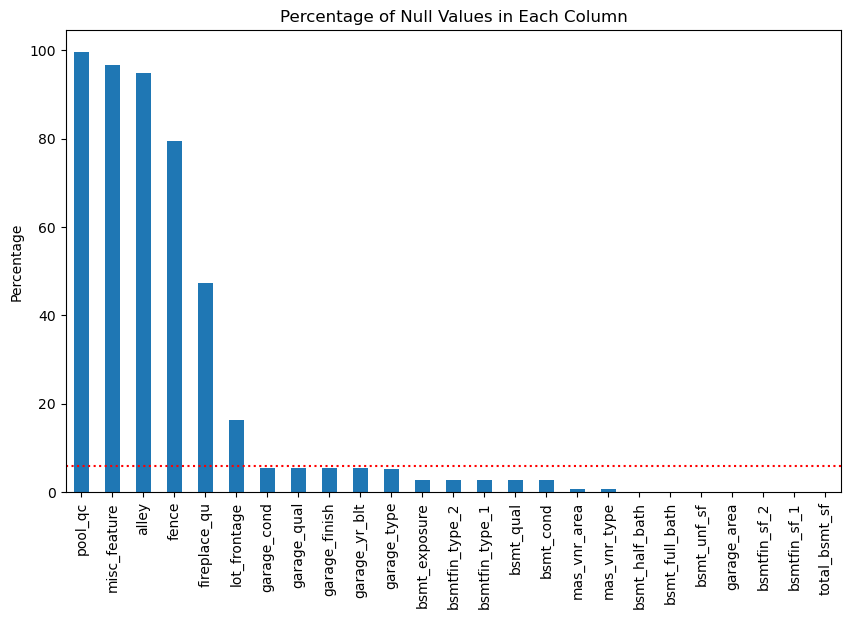

In [16]:
#calculate the percentage of nulls in each column
null_percent = df.isnull().mean() * 100

#filter out columns with no nulls
null_percent = null_percent[null_percent > 0]

#sort in descending order
null_percent = null_percent.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
null_percent.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Null Values in Each Column')
plt.axhline(y=6, color='r', linestyle='dotted')
plt.show()

In [17]:
#drop columns with too many nulls
df = df.drop(columns=["alley", "fence","pool_qc", "misc_feature","fireplace_qu","lot_frontage"])

In [18]:
#grab all the columns that are objects (categorical) this way we can filter them to see which we would like to stratify on
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print(object_cols)

['ms_subclass', 'ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'sale_type']


**The y-axis of the chart below shows the number of categories in each categorical column, showing its contribution to the increase in dimensions stemming from one hot encoding. The color shading of the bar chart are the results of apply the Herfindahl Hirschman Index to the categories of the categorical variable in order to summarize its class imbalance in a single metric. We see deeply imbalanced classes represented by the higher end of the HHI calculation. For context, a single category comprising 100% of observations would have the maximum value of 10,000. Our data has several categories above 8,000. The highly imbalanced classes are probably a result of that category not applying to most of the obsevations (i.e. many of the houses not having an unfinished basement, and therefore having a value of "0" for the category).** <br>

**Undersampling from the majority class is not a good option to address this issue as the high dimensionality of our data already leaves us with a relatively low obsevation/feature ratio putting our model(s) at risk of overfitting.**

In [19]:
#calculate the HHI value

hhi_values = []

for col in object_cols:
    #get value counts for each category (as percentages)
    value_counts = df[col].value_counts(normalize=True)
    
    #calculate the HHI value as the sum of the squares of the percentages
    hhi_value = ((value_counts*100)**2).sum()
    
    hhi_values.append(hhi_value)

df_hhi = pd.DataFrame({'Column': object_cols, 'HHI': hhi_values, 'NumUnique': [df[col].nunique() for col in object_cols]})

rank = df_hhi['HHI'].argsort().argsort()  # Rank items in ascending order
palette = sns.color_palette("coolwarm", len(df_hhi))

df_hhi.sort_values('Column', inplace=True)

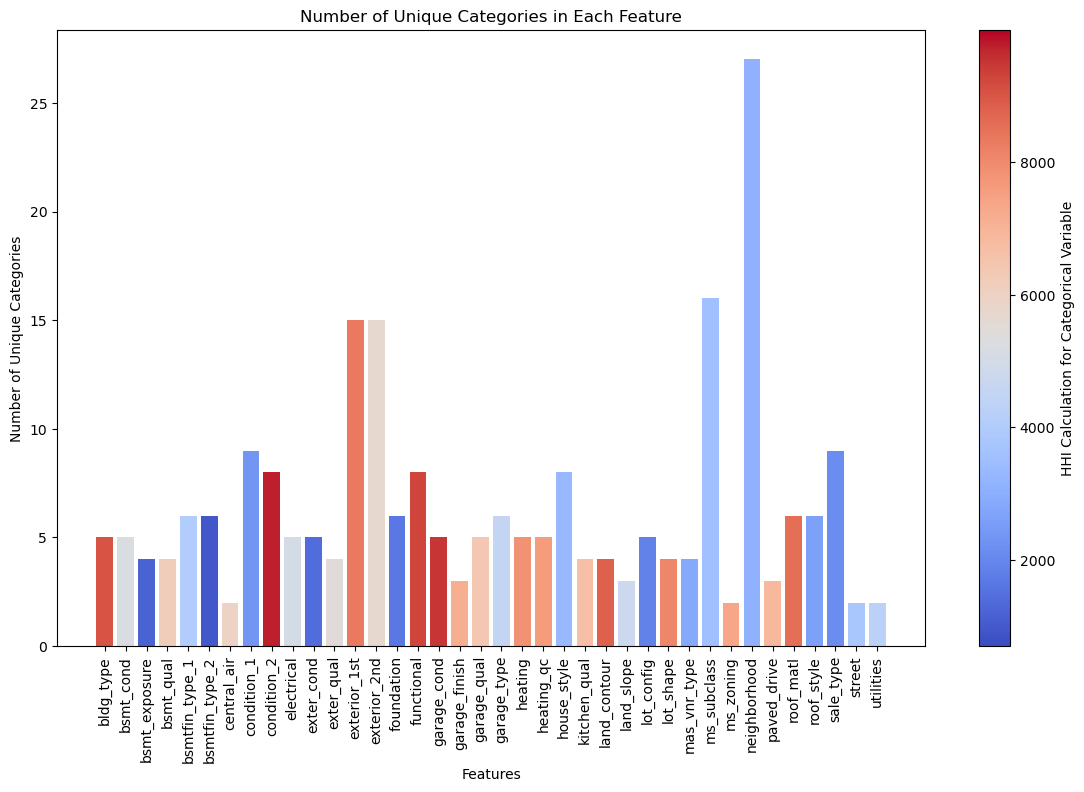

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(df_hhi['Column'], df_hhi['NumUnique'], color=np.array(palette[::-1])[rank])

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=df_hhi['HHI'].min(), vmax=df_hhi['HHI'].max()))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('HHI Calculation for Categorical Variable')

ax.set_title('Number of Unique Categories in Each Feature')
ax.set_xlabel('Features')
ax.set_ylabel('Number of Unique Categories')
plt.xticks(rotation=90) 

plt.show()

In [21]:
# Get a list of features with HHI > 6000
high_hhi_features = df_hhi[df_hhi['HHI'] > 6000]['Column'].tolist()

print(high_hhi_features)

['bldg_type', 'bsmt_cond', 'bsmtfin_type_2', 'central_air', 'condition_1', 'condition_2', 'electrical', 'exter_cond', 'functional', 'garage_cond', 'garage_qual', 'heating', 'land_contour', 'land_slope', 'ms_zoning', 'paved_drive', 'roof_matl', 'roof_style', 'sale_type', 'street', 'utilities']


**Performing an initial f-test here to reduce the number of variables that we stratify on in our train test split. we will have to do f-tests on the variables that we impute values for, as well as for the pca vars.**

In [22]:
features = object_cols

vars_ftest_fail = []
features_with_high_pvalue = []

for feature in features:
    categories = df[feature].unique()
    samples = [df['saleprice-misc_val'][df[feature] == category] for category in categories]
    fvalue, pvalue = stats.f_oneway(*samples)
    
    #add metrics to the results list if p-value is greater than 0.01
    if pvalue > .01:
        vars_ftest_fail.append((feature, fvalue, pvalue))
        features_with_high_pvalue.append(feature)

for feature, fvalue, pvalue in vars_ftest_fail:
    print(f"Feature: {feature}, F-value: {fvalue}, P-value: {pvalue}")

print("Features with P-value > 0.01:", features_with_high_pvalue)


Feature: street, F-value: 1.6328201883023594, P-value: 0.2014685374020848
Feature: utilities, F-value: 0.2969370474795094, P-value: 0.5858725709513602
Features with P-value > 0.01: ['street', 'utilities']


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [23]:
stratify_candidates= set(object_cols)-set(features_with_high_pvalue)-set(high_hhi_features)
print(stratify_candidates)

{'heating_qc', 'exter_qual', 'lot_config', 'mas_vnr_type', 'bsmt_exposure', 'garage_finish', 'kitchen_qual', 'exterior_1st', 'exterior_2nd', 'lot_shape', 'neighborhood', 'bsmt_qual', 'ms_subclass', 'bsmtfin_type_1', 'foundation', 'garage_type', 'house_style'}


**Since we don't have enough observations to stratify on all of the features (we actually don't have enough observations to stratify on even small subsets of the features), we would like to capture as much as of the categorical variables as we can. Since cramer's V is analagous to the correlation between categorical variables, we summed the cramer's V of each categorical variable and will use the variable with the highest of this metric, "neighborhood" to stratify on because this variable has an extemely high covariance with the other features and therefore will capture a great deal of its explanatory power**

In [24]:
cols = stratify_candidates

#calc Cramer's V for all combinations of columns and store them in a dictionary
results = {}
for col1, col2 in combinations(cols, 2):
    data = pd.crosstab(df[col1], df[col2])
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data).sum()
    minDim = min(data.shape) - 1
    V = np.sqrt((X2/n) / minDim)
    results.setdefault(col1, 0)
    results.setdefault(col2, 0)
    results[col1] += V
    results[col2] += V

#sort the results in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for col, total_V in sorted_results:
    print(f"Sum of Cramer's V for {col}: {total_V}")

Sum of Cramer's V for neighborhood: 6.022117647653735
Sum of Cramer's V for bsmt_qual: 5.306521473393584
Sum of Cramer's V for ms_subclass: 5.242866499151695
Sum of Cramer's V for garage_finish: 5.23358363190031
Sum of Cramer's V for exter_qual: 5.07666044283906
Sum of Cramer's V for exterior_2nd: 4.670922450989514
Sum of Cramer's V for foundation: 4.6577374308491235
Sum of Cramer's V for kitchen_qual: 4.603027192321567
Sum of Cramer's V for exterior_1st: 4.587767767915205
Sum of Cramer's V for garage_type: 3.921495093900678
Sum of Cramer's V for house_style: 3.785951245234605
Sum of Cramer's V for bsmtfin_type_1: 3.7258951038924284
Sum of Cramer's V for heating_qc: 3.54655669566337
Sum of Cramer's V for mas_vnr_type: 3.3894617864785856
Sum of Cramer's V for bsmt_exposure: 3.03161580586306
Sum of Cramer's V for lot_shape: 2.569285884796574
Sum of Cramer's V for lot_config: 1.6735382740812097


In [25]:
df.shape

(1914, 75)

<font size="8">Split data into train and verification</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**Since we will create a regression to fill the nulls and then perform pca, we will need to split the data into training and verification before we do either of those, because we will have to do those two steps separately to avoid data leakage. I did that to avoid data leakage and I will need the indexes, because I will need to perform the pca and imputations separately for the trianing and verification data**

In [26]:
#define the column names
size_cols = ['lot_area','bsmtfin_sf_1' ,'bsmtfin_sf_2', 'bsmt_unf_sf', 
             'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_area', 'wood_deck_sf',
             'open_porch_sf', 'enclosed_porch', 'pool_area', 'mas_vnr_area', 'screen_porch', '3ssn_porch']

age_vars_cols = ['year_built', 'year_remod_add', 'garage_yr_blt', 'yr_sold','mo_sold']

roommage_vars_cols = ['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath',
                      'bedroom_abvgr','kitchen_abvgr', 'totrms_abvgrd','fireplaces']

environment_vars_cols = ['street','neighborhood']

categories_of_house_vars_cols = ['roof_style','roof_matl','exterior_1st',
                                 'exterior_2nd','mas_vnr_type', 'foundation','bsmt_exposure','heating',
                                 'heating_qc',
                                 'central_air','electrical','garage_type','paved_drive', 'ms_subclass',
                                 'bldg_type','lot_shape','land_contour','utilities', 'lot_config',
                                 'land_slope','condition_1','condition_2','house_style']

quality_of_house_vars_cols = ['overall_qual', 'overall_cond', 'exter_qual',
                              'exter_cond','bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 
                              'kitchen_qual', 'functional','garage_qual', 'garage_finish', 
                              'garage_cond']

In [27]:
#concactenate the lists
all_columns = size_cols + age_vars_cols + roommage_vars_cols + ['neighborhood']

#create df_X_temp and df_y
df_X_temp = df[all_columns]
df_y = df['saleprice-misc_val']

#split
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X_temp, df_y, test_size=0.2, 
                                                                                        stratify=df_X_temp['neighborhood'], random_state=42)


In [28]:
#drop 'neighborhood' from feature set because you wanted to stratify according to the neighborhood feature, but you don't want the categorical variable
#included in the RandomForest estimator
df_X_train_no_neighborhood = df_X_train.drop(columns=['neighborhood'])
df_X_test_no_neighborhood = df_X_test.drop(columns=['neighborhood'])

original_columns =  df_X_train.columns

In [29]:
df_X_temp.shape

(1914, 30)

In [30]:
df_X_train.shape

(1531, 30)

In [84]:
df_X_train_no_neighborhood.shape

(1531, 29)

In [91]:
df_X_temp.shape

(1914, 30)

<font size="8">Imputations</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [31]:
#call the percentage of nulls in each column
null_percent = df_X_train.isnull().mean() * 100

null_percent_continuous = null_percent[(null_percent > 0) &
                                       (df_X_train.dtypes.isin([np.dtype('float64'), np.dtype('int64')]))]

#sort
null_percent_continuous = null_percent_continuous.sort_values(ascending=False)

# Print the result
print(null_percent_continuous)

garage_yr_blt     4.898759
mas_vnr_area      0.653168
bsmt_full_bath    0.065317
bsmt_half_bath    0.065317
dtype: float64


In [32]:
#export the pandas dataframes as csv
df_X_train_no_neighborhood.to_csv('df_X_train_no_neighborhood.csv', index=False)
df_X_test_no_neighborhood.to_csv('df_X_test_no_neighborhood.csv', index=False)

**The below random forest was run in google colab to leverage the premium GPUs that can train significantly faster**

**#Define the parameter grid for the RandomForestRegressor** <br>
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [5, 10, 15, 20],
    'min_child_weight': [1, 2, 4],
}

xgb_reg = xgb.XGBRegressor()

**#Initialize GridSearchCV** <br>
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3)

**#initialize Iterative Imputer** <br>
imputer_xgb = IterativeImputer(estimator=grid_search_xgb, max_iter=10, random_state=42)

In [34]:
#load the  dataframe
df_X_train_imputed = load('/Users/nicholassanso/Desktop/GA/projects/project-2/house_saleprice_predictor/df_X_train_imputed.joblib')

#load the dataframe
df_X_test_imputed = load('/Users/nicholassanso/Desktop/GA/projects/project-2/house_saleprice_predictor/df_X_test_imputed.joblib')

In [85]:
df_X_train_imputed.shape

(1531, 29)

<font size="8"> Robust Scaler and then Standard Scaler</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


While regression does not requirefeature to be the same scale there are two main advanatages to applying standard scaler to a dataset that will be used in a regression model:
1) Applying standard scaler makes your coeffficient of the same magnitude and allowing for direct comparisons, increasing the interpretabiltiy of the model.
2) Allows for the proper use of regularization techniques likeridge and lasso where feature scaling is performed based on the size of the coefficeints and thus having uniformly scaled coefficients is important.


**we will use a form of robust scaling that is less sensitive to outliers to perform our pca, we will use the interquartile range to reduce our sensitivity**
**we could use the pairplots to identify individual outliers and then drop them by index**
**we could just normalize using standard deviation, and then winsorize the data by dropping all values above a certain SD**
**winsorize the contiuous features to deal with outliers**

In [35]:
pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler()), 
    ('standard_scaler', StandardScaler())  
])

In [36]:
np_X_train_imputed_scaled = pipeline.fit_transform(df_X_train_imputed)
np_X_test_imputed_scaled = pipeline.transform(df_X_test_imputed)

In [58]:
df_X_train_imputed_scaled = pd.DataFrame(np_X_train_imputed_scaled, columns=df_X_train_imputed.columns)
df_X_test_imputed_scaled = pd.DataFrame(np_X_test_imputed_scaled, columns=df_X_test_imputed.columns)

In [82]:
df_X_train_imputed_scaled.shape

(1531, 29)

<font size="8">Test for correlation and linearity for PCA</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**The chart below shows the justification for PCA among the df_X_train_imputed_transformed dataframe.**

In [59]:
# Create correlation matrix
corr = df_X_train_imputed_scaled.corr()

# Create a mask for correlations above 0.6 and not equal to 1
mask = (abs(corr) >= 0.6) & (abs(corr) < 1)

# Get the variable names
pca_candidates = mask.any()

# Get the variable names of features that returned True
true_pca_candidates = pca_candidates[pca_candidates].index

# Print the variable names
print(true_pca_candidates)


Index(['bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf',
       'year_built', 'year_remod_add', 'garage_yr_blt', 'bsmt_full_bath',
       'half_bath', 'bedroom_abvgr', 'totrms_abvgrd'],
      dtype='object')


**heatmpas, when they show that there are high correlations between the features can also provide comfort over the linearity of the features, because although that correlation could happen in a quadratic of exponential fashion, it could also be a linear relationship**

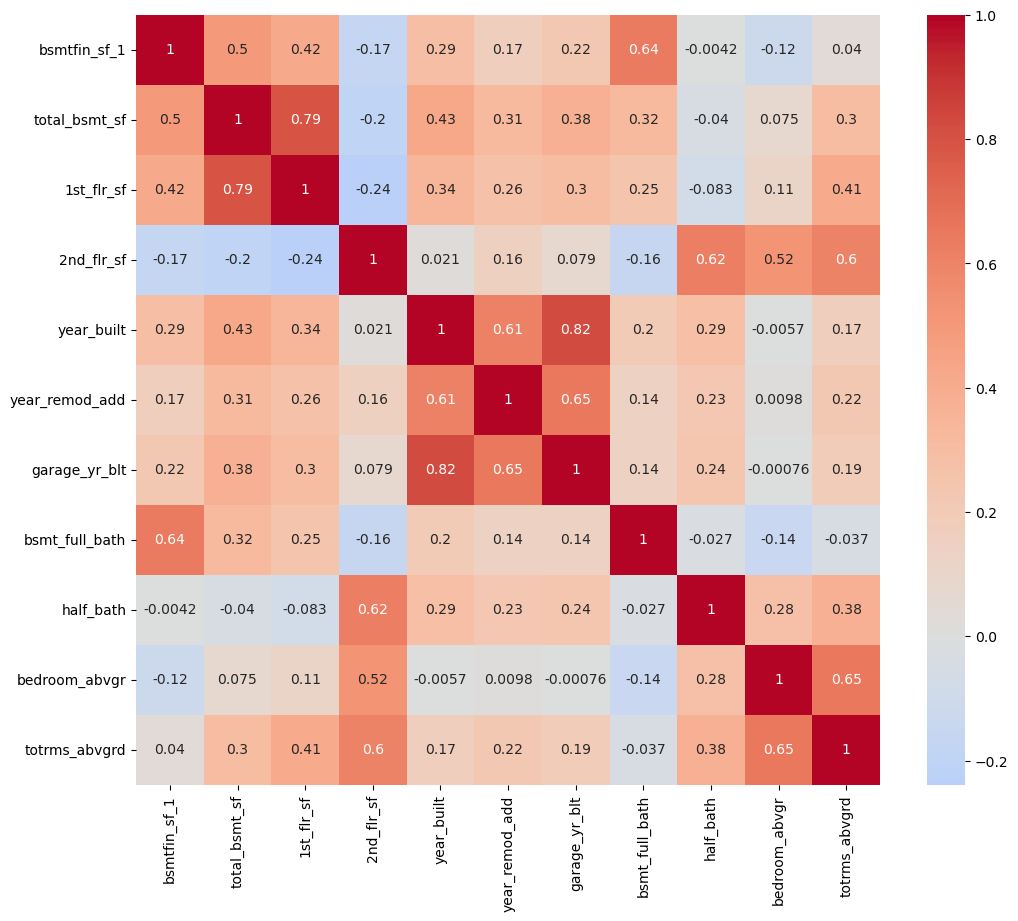

In [60]:
#filter the correlation matrix to include only the variables of interest
filtered_corr = corr.loc[true_pca_candidates, true_pca_candidates]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', center=0)
plt.show()

<font size="8">PCA</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [61]:
#instantiate pca
pca = PCA(n_components=3, random_state=42)

In [62]:
# Perform PCA on the selected columns from the triannig data set
np_X_train_imputed_scaled_pca = pca.fit_transform(df_X_train_imputed_scaled[true_pca_candidates])

In [64]:
# Perform PCA on the selected columns from the testing data set
np_X_test_imputed_scaled_pca = pca.transform(df_X_test_imputed_scaled[true_pca_candidates])

In [74]:
# convert back to a df
df_train_pca = pd.DataFrame(data=np_X_train_imputed_scaled_pca, columns=['PC1', 'PC2', 'PC3'])

# convert back to a df
df_test_pca = pd.DataFrame(data=np_X_test_imputed_scaled_pca, columns=['PC1', 'PC2', 'PC3'])

In [86]:
df_train_pca.shape

(1531, 3)

In [75]:
#exclude the variables used in PCA from the original DataFrame and concatenate this df with the PCA df
df_X_train_imputed_scaled_excluding_pca_vars = df_X_train_imputed_scaled.drop(columns=true_pca_candidates)

#exclude the variables used in PCA from the original DataFrame and concatenate this df with the PCA df
df_X_test_imputed_scaled_excluding_pca_vars = df_X_test_imputed_scaled.drop(columns=true_pca_candidates)

In [87]:
df_X_train_imputed_scaled_excluding_pca_vars.shape

(1531, 18)

In [77]:
df_X_train_imputed_scaled_pca_NonPca = pd.concat([df_X_train_imputed_scaled_excluding_pca_vars, df_train_pca], axis=1)
df_X_test_imputed_scaled_pca_NonPca = pd.concat([df_X_test_imputed_scaled_excluding_pca_vars, df_test_pca], axis=1)

In [78]:
df_X_train_imputed_scaled_pca_NonPca.shape

(1531, 21)

In [79]:
df_X_test_imputed_scaled_pca_NonPca.shape

(383, 21)

<font size="8">test linearity and multicollinaerty (with PCA var)</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**and in the dataframe, befoer we append our neighborhood variable we see very low correlations among varibales, and unlikely to have milticollinearity**

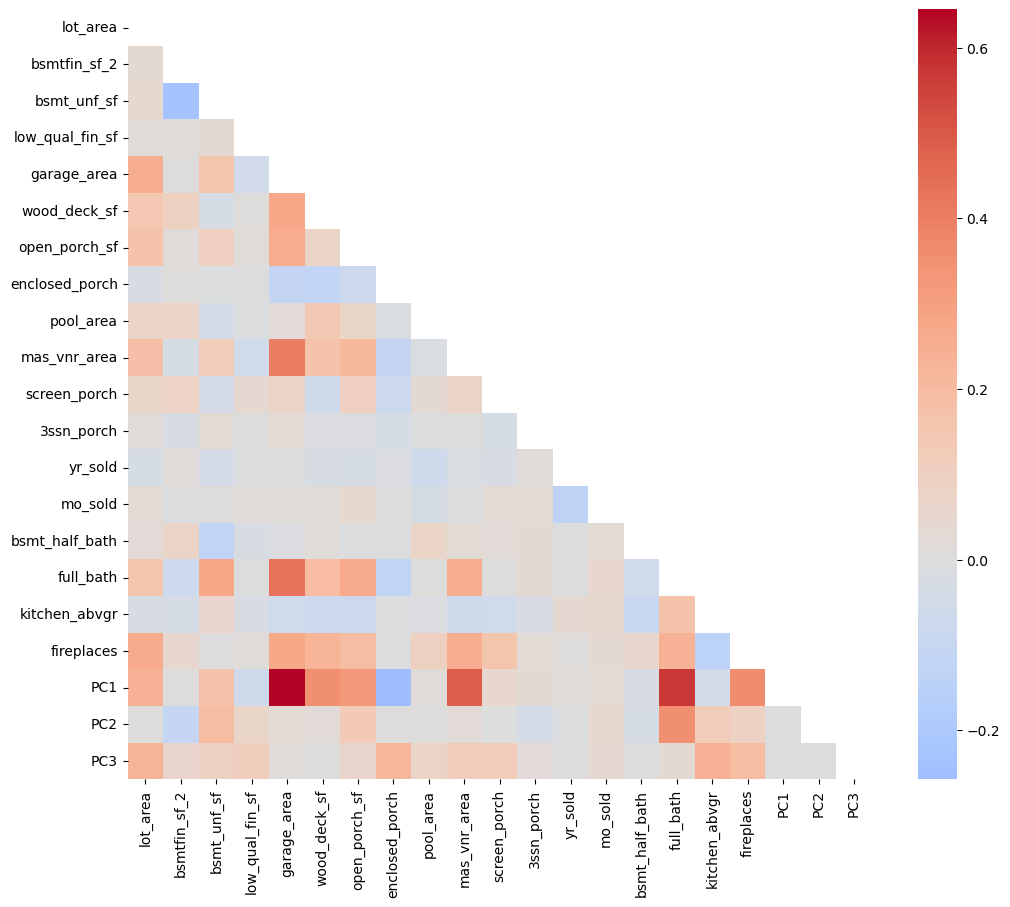

In [141]:
corr_matrix = df_X_train_imputed_scaled_pca_NonPca.corr()

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, mask=mask)
plt.show()

<font size="8">One Hot Encoding</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [102]:
df_X_train_imputed_scaled_pca_NonPca_index = df_X_train_imputed_scaled_pca_NonPca.reset_index(drop=True)
df_X_train_index = df_X_train.reset_index(drop=True)

df_X_train_imputed_scaled_pca_NonPca_nieghbor= pd.concat([df_X_train_imputed_scaled_pca_NonPca_index, df_X_train_index['neighborhood']], axis=1)

In [112]:
df_X_test_imputed_scaled_pca_NonPca_index = df_X_test_imputed_scaled_pca_NonPca.reset_index(drop=True)
df_X_test_index = df_X_test.reset_index(drop=True)

df_X_test_imputed_scaled_pca_NonPca_nieghbor= pd.concat([df_X_test_imputed_scaled_pca_NonPca_index, df_X_test_index['neighborhood']], axis=1)

In [113]:
df_X_test_imputed_scaled_pca_NonPca_nieghbor.shape

(383, 22)

In [103]:
df_X_train_imputed_scaled_pca_NonPca_nieghbor.shape

(1531, 22)

In [115]:
df_train_complete = pd.get_dummies(df_X_train_imputed_scaled_pca_NonPca_nieghbor, columns=['neighborhood'])
df_test_complete =pd.get_dummies(df_X_test_imputed_scaled_pca_NonPca_nieghbor, columns=['neighborhood'])

In [107]:
df_train_complete.shape

(1531, 48)

In [116]:
df_test_complete.shape

(383, 47)

In [128]:
df_X_temp['neighborhood'].value_counts()

NAmes      306
CollgCr    180
OldTown    163
Edwards    142
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     85
Mitchel     81
BrkSide     76
Crawfor     70
IDOTRR      48
NoRidge     48
Timber      48
StoneBr     38
Somerst     29
SWISU       27
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Name: neighborhood, dtype: int64

**difference in columns is likely due sklearn's "train_test_split funciton" putting all the observations of one of the less frequent neighborhoods in only the training data. Code below ensures that there are equal number of oclums. in both my training and test data sets.**

In [118]:
df_test_complete_2 = df_test_complete.reindex(columns = df_train_complete.columns, fill_value=0)

In [119]:
df_test_complete_2.shape

(383, 48)

**correlations in the final dataframe are extremely low.**

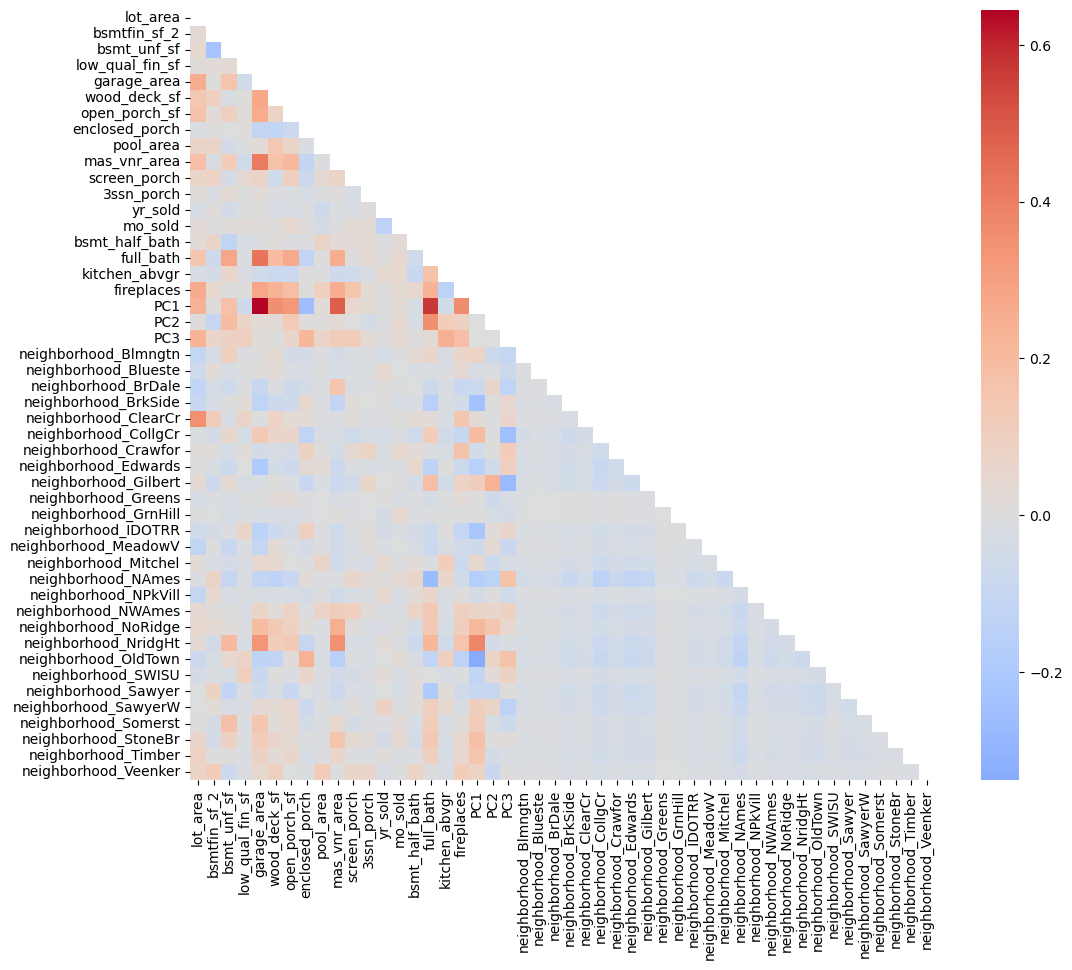

In [129]:
corr_matrix = df_train_complete.corr()

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, mask=mask)

plt.show()

<font size="8">Fitting the Model and Evaluation</font> <br>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)



In [109]:
lr = LinearRegression()

In [130]:
# Train the model using the training sets
lr.fit(df_train_complete, df_y_train)

# Make predictions using the testing set
y_pred = lr.predict(df_train_complete)

In [131]:
coefficients = pd.DataFrame(lr.coef_, df_train_complete.columns)
coefficients.columns = ['Coefficient']
print(coefficients)

                        Coefficient
lot_area                6123.546941
bsmtfin_sf_2            1110.791870
bsmt_unf_sf             -127.731774
low_qual_fin_sf          566.295754
garage_area             8247.448962
wood_deck_sf            2714.760368
open_porch_sf           1366.069188
enclosed_porch          2244.614822
pool_area                -85.172050
mas_vnr_area            7972.342655
screen_porch            5423.180380
3ssn_porch              1111.344711
yr_sold                 -424.589771
mo_sold                -1312.814000
bsmt_half_bath         -1147.544467
full_bath               5518.965376
kitchen_abvgr          -6214.040698
fireplaces              7130.701278
PC1                    20375.981326
PC2                     4664.817054
PC3                     2333.863755
neighborhood_Blmngtn   -4116.486381
neighborhood_Blueste  -12197.227326
neighborhood_BrDale   -39677.873734
neighborhood_BrkSide    -674.405216
neighborhood_ClearCr  -17586.936458
neighborhood_CollgCr  -10964

**83.82% of the variation in the sale price can be explained by the explanatory variables. After dividing the training data into 5 folds, 81.36% of the variation in the sale price can be explained by the explanatory variables on average. This indicates that the model is not ovefit. Furthermore we can see that the R^2 values for the cross validation data sets have a standard deviation of just 4.03%. 68% (1 standard deviation worth) of training data predicitons had an error of $32,307 or less.**

In [182]:
print(f"The mean sale price is: ${df['saleprice'].mean()}")
print(f"The standard deviation of sale price is: ${df['saleprice'].std()}")

The mean sale price is: $180979.85475444095
The standard deviation of sale price is: $79689.84081499004


In [174]:
print(f"The training score is: {lr.score(df_train_complete, df_y_train)}")
print(f"The test score is: {lr.score(df_test_complete_2, df_y_test)}")

The training score is: 0.8382693966967505
The test score is: 0.7509625433496644


In [176]:
print(f"Train cross val score: {cross_val_score(lr, df_train_complete, df_y_train).mean()}")
print(f"Test cross val score: {cross_val_score(lr, df_test_complete_2, df_y_test).mean()}")

Train cross val score: 0.8136490215663816
Test cross val score: 0.6730048683247567


In [177]:
cross_val_scores_train= cross_val_score(lr, df_train_complete, df_y_train)
cross_val_scores_test= cross_val_score(lr, df_test_complete_2, df_y_test)

std_dev_train = np.std(cross_val_scores_train)
std_dev_test = np.std(cross_val_scores_test)

print(f"The standard deviation of cross validation scores for training data is: {std_dev_train}")
print(f"The standard deviation of cross validation scores for test data is: {std_dev_test}")

The standard deviation of cross validation scores for training data is: 0.040341432408634914
The standard deviation of cross validation scores for test data is: 0.3308123862198292


In [178]:
print(f"Train RMSE: {mean_squared_error(df_y_train, lr.predict(df_train_complete), squared = False)}")
print(f"Test RMSE: {mean_squared_error(df_y_test, lr.predict(df_test_complete_2), squared = False)}")

Train RMSE: 32307.13822525738
Test RMSE: 38417.62787561644


<font size="8">Evaluation of Residuals</font> <br>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)

In [200]:
test_y_pred = lr.predict(df_test_complete_2)
train_y_pred = lr.predict(df_train_complete)

In [208]:
test_residuals= test_y_pred - df_y_test
test_percentage_residuals = (test_residuals / df_y_test) * 100

train_residuals= train_y_pred- df_y_train
train_percentage_residuals = (train_residuals / df_y_train) * 100

<font size="6">Normality assumption</font>
<a id='destination_cell_9'></a>

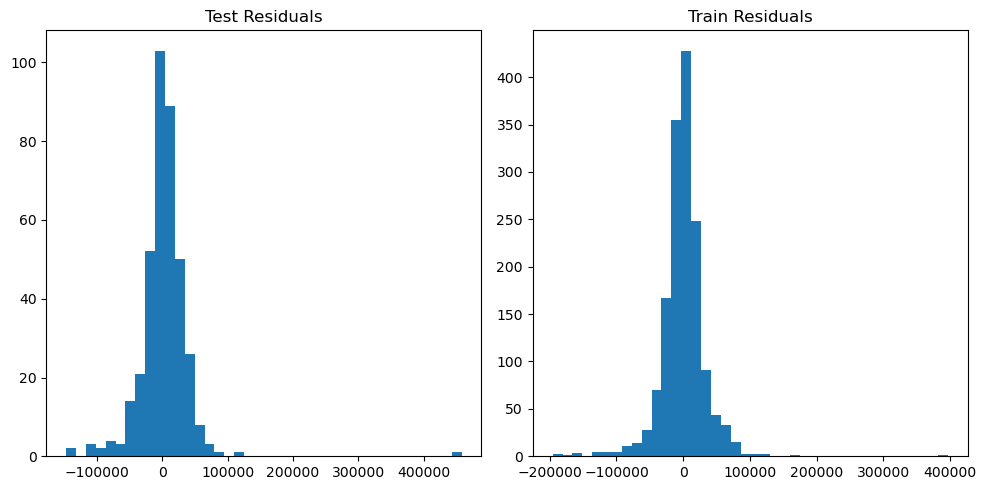

In [234]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
axs[0].hist(test_residuals, bins = 40)
axs[0].set_title('Test Residuals')

# Plot train_residuals
axs[1].hist(train_residuals, bins = 40)
axs[1].set_title('Train Residuals')

# Display the plot
plt.tight_layout()
plt.show()


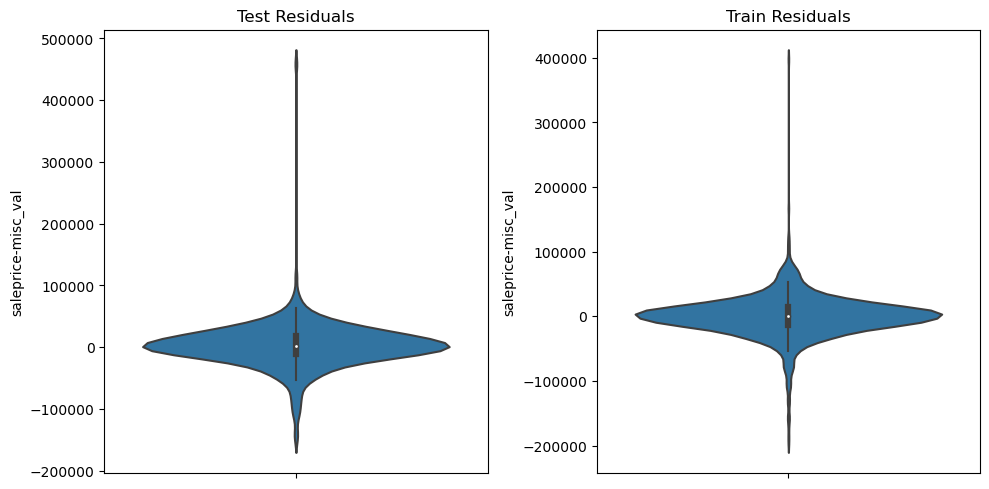

In [236]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
sns.violinplot(ax=axs[0], y=test_residuals)
axs[0].set_title('Test Residuals')

# Plot train_residuals
sns.violinplot(ax=axs[1], y=train_residuals)
axs[1].set_title('Train Residuals')

# Display the plot
plt.tight_layout()
plt.show()

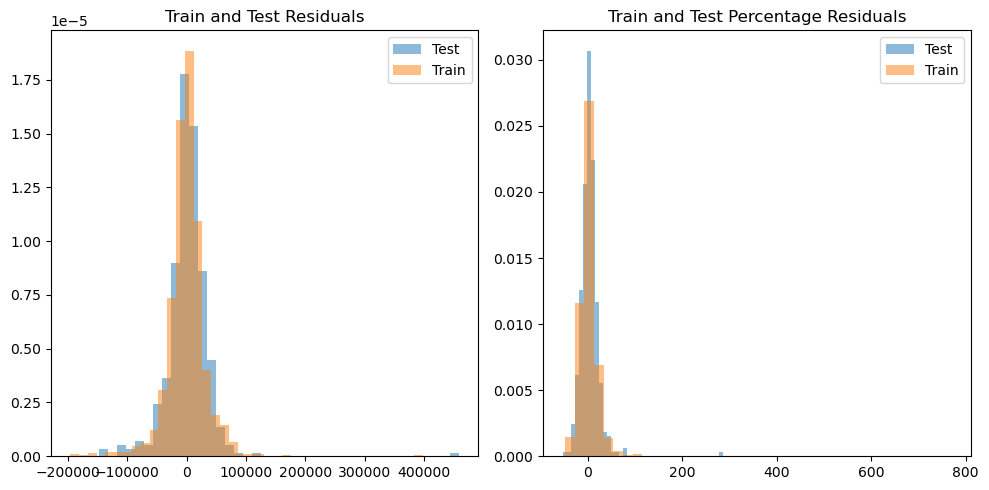

In [224]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Overlay test_residuals and train_residuals
axs[0].hist(test_residuals, bins = 40, alpha=0.5, label='Test', density=True)
axs[0].hist(train_residuals, bins = 40, alpha=0.5, label='Train', density=True)
axs[0].set_title('Train and Test Residuals')
axs[0].legend(loc='upper right')

# Overlay train_percentage_residuals and test_percentage_residuals
axs[1].hist(test_percentage_residuals, bins = 40, alpha=0.5, label='Test', density=True)
axs[1].hist(train_percentage_residuals, bins = 40, alpha=0.5, label='Train', density=True)
axs[1].set_title('Train and Test Percentage Residuals')
axs[1].legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

<font size="6">Homoskedasticity Assumption</font> <br>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)

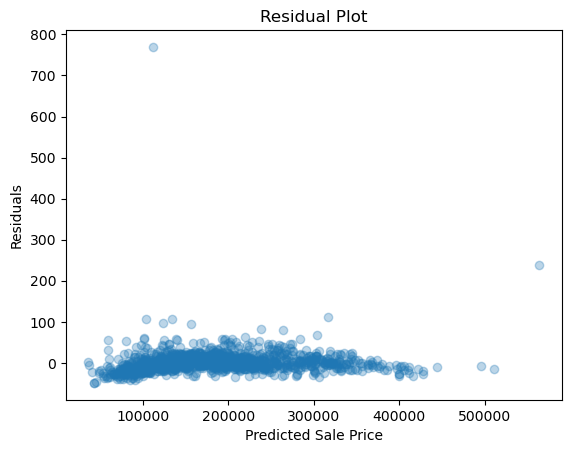

In [237]:
plt.scatter(train_y_pred, train_percentage_residuals, alpha =.3)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

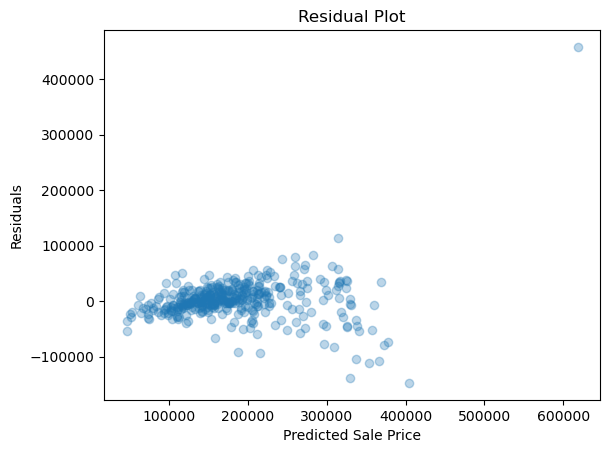

In [198]:
plt.scatter(test_y_pred, test_residuals, alpha =.3)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

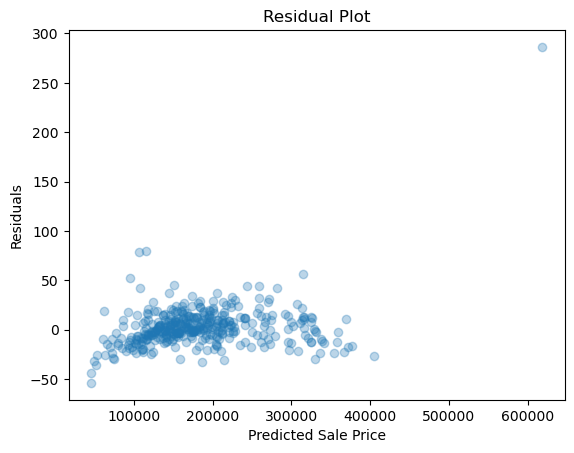

In [207]:
plt.scatter(test_y_pred, test_percentage_residuals, alpha =.3)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()